In [99]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize, LinearConstraint, Bounds
import yfinance as yf
import matplotlib.pyplot as plt

In [100]:
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "META", "NVDA", "JPM", "XOM", "PG", "V"]

prices = yf.download(tickers, start = '2015-01-01', auto_adjust=False)['Adj Close']
prices.head()


[*********************100%***********************]  10 of 10 completed


Ticker,AAPL,AMZN,GOOGL,JPM,META,MSFT,NVDA,PG,V,XOM
Date,,,,,,,,,,
2015-01-02,24.261045,15.4260,26.319651,46.948078,78.021973,39.998695,0.483066,66.983505,61.462467,58.967125
2015-01-05,23.577570,15.1095,25.818159,45.490578,76.768845,39.630878,0.474906,66.665024,60.105774,57.353676
2015-01-06,23.579796,14.7645,25.180983,44.311043,75.734512,39.049221,0.460508,66.361359,59.718456,57.048779
2015-01-07,23.910437,14.9210,25.106924,44.378670,75.734512,39.545334,0.459308,66.709450,60.518585,57.626835
2015-01-08,24.829128,15.0230,25.194401,45.370365,77.753441,40.708698,0.476586,67.472305,61.330288,58.586014


In [101]:
def expectedreturns(prices, days = 252):
    if not isinstance(prices, (pd.Series, pd.DataFrame)):
        raise TypeError("Format prices as a pd.Series")
    returns = prices.pct_change(fill_method=None).dropna()
    exp_ret = returns.mean() * days
    return exp_ret

In [102]:
def covariancematrix(prices, days = 252):
    if not isinstance(prices, (pd.Series, pd.DataFrame)):
        raise TypeError("Formate prices as pd.Series")
    returns = prices.pct_change(fill_method=None).dropna()
    covariance = returns.cov() * days

    return covariance

In [104]:
def minimumvariance(prices, target_return):
    if not isinstance(prices, (pd.Series, pd.DataFrame)):
        raise TypeError("Prices should be a pd.Series")
    
    bounds = Bounds(0,1)
    linear_constraint = LinearConstraint(np.ones(len(tickers)), 1, 1)

    w0 = np.ones(len(tickers)) / len(tickers)
    
    exp_ret = expectedreturns(prices)
    
    cov_matrix = covariancematrix(prices)

    target_constraint = {'type': 'eq', 'fun': lambda w: exp_ret.T @ w - target_return}
    
    variance = lambda w: w.T @ cov_matrix @ w

    res1 = minimize(variance, w0, args = (), method = 'SLSQP', bounds=bounds, constraints=[linear_constraint, target_constraint])
    
    return res1

In [163]:
def efficientfrontier(prices, data_points = 250):
    if not isinstance(prices, (pd.Series, pd.DataFrame)):
        raise TypeError("Prices should be a pd.Series")
    
    exp_ret = expectedreturns(prices)
    cov_matrix = covariancematrix(prices)
    
    bounds = Bounds(0,1)
    linear_constraint = LinearConstraint(np.ones(len(tickers)), 1, 1)

    w0 = np.ones(len(tickers)) / len(tickers)

    ret = lambda w: -exp_ret.T @ w # negative so we can find maximum
    max_ret_port = minimize(ret, w0, args=(), method = 'SLSQP', constraints=linear_constraint, bounds=bounds) 

    var = lambda w : w.T @ cov_matrix @ w
    min_var_port = minimize(var, w0, args = (), method = "SLSQP", constraints=linear_constraint, bounds=bounds)

    min_return = exp_ret.T @ min_var_port.x
    max_return = exp_ret.T @ max_ret_port.x 

    trs = np.linspace(min_return, max_return, data_points, True)

    data = np.zeros((2, data_points))
    weight_list = []

    for tr in trs:
        indx = np.where( trs == tr)
        result = minimumvariance(prices, tr)
        if result.success:
            risk = np.sqrt(result.fun)
            weights = result.x
            weight_list.append(weights)
            returns = np.dot(exp_ret.T, weights)
            data[0, indx] = risk
            data[1, indx] = returns
    
    return data, weight_list


In [162]:
def max_sharpe(prices, r_f = 0, data_points = 250):
    if not isinstance(prices, (pd.Series, pd.DataFrame)):
        raise TypeError("Format prices as a pd.Series")
    
    ef = efficientfrontier(prices, data_points)

    ef_data, weights = ef

    sharpe = (ef_data[1, : ] - r_f) / ef_data[0, : ]

    maxsh_idx = np.argmax(sharpe)
    maxsh = sharpe[maxsh_idx]

    return maxsh, weights[maxsh_idx]

In [160]:
def plotting(prices, maxsharpe = False):

    ef = efficientfrontier(prices)
    exp_ret = expectedreturns(prices)
    cov_matrix = covariancematrix(prices)
    ms = max_sharpe(prices)

    if maxsharpe:
        value, weights = ms
        returns = exp_ret.T @ weights
        risk = np.sqrt(weights.T @ cov_matrix @ weights)
        plt.scatter(risk, returns, marker ='d', c='r', s = 100, label=f"Max Sharpe (SR={value:.2f})")

    ef_points, _ = ef
    x, y = ef_points
    plt.plot(x,y, label = 'Efficient Frontier')
    plt.title("Efficient Frontier")
    plt.xlabel("Risk")
    plt.ylabel("Expected Return")
    plt.legend()
    plt.show()

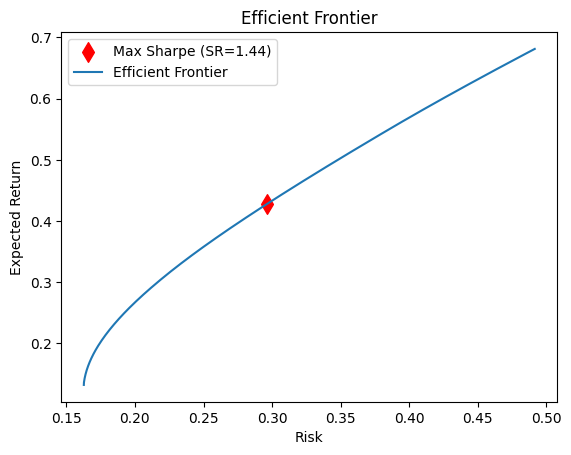

In [164]:
plotting(prices,True)